In [ ]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score #for accuracy and scores
import re
import nltk
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer
from keras.layers import Convolution1D, GlobalMaxPooling1D
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, Embedding,LSTM, Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from sklearn.metrics import accuracy_score
import tensorflow as tf

In [ ]:
# Loading the dataset into Pandas
    

path = '/content/drive/MyDrive/Tweets.csv'
data_df = pd.read_csv(path)


#Pandas: whats the data row count?
data_df.shape
    
#Pandas: whats the distribution of the data?
data_df.describe()
    
#Pandas: What types of data do i have?
data_df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [ ]:
data_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
sentiment_counts = data_df.airline_sentiment.value_counts()
number_of_tweets = data_df.tweet_id.count()
print(sentiment_counts)

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


Text(0.5, 1.0, 'Count of Type of Sentiment')

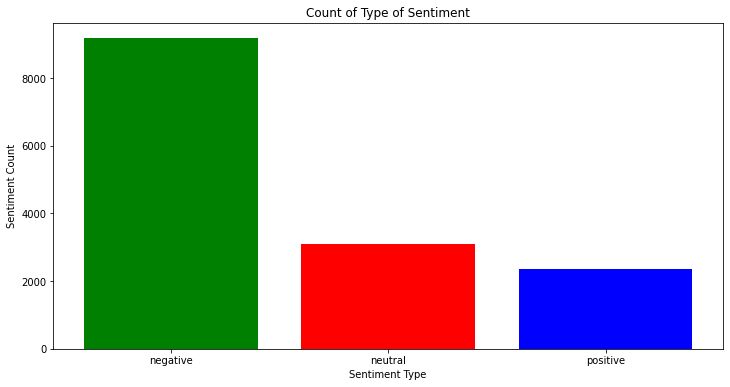

In [ ]:
counter = data_df.airline_sentiment.value_counts()
index = [1,2,3]
plt.figure(1,figsize=(12,6))
plt.bar(index,counter,color=['green','red','blue'])
plt.xticks(index,['negative','neutral','positive'],rotation=0)
plt.xlabel('Sentiment Type')
plt.ylabel('Sentiment Count')
plt.title('Count of Type of Sentiment')

In [ ]:
# Count tweets
print(len(data_df))

14640


            Percent Negative
American            0.710402
Delta               0.429793
Southwest           0.490083
US Airways          0.776862
United              0.688906
Virgin              0.359127


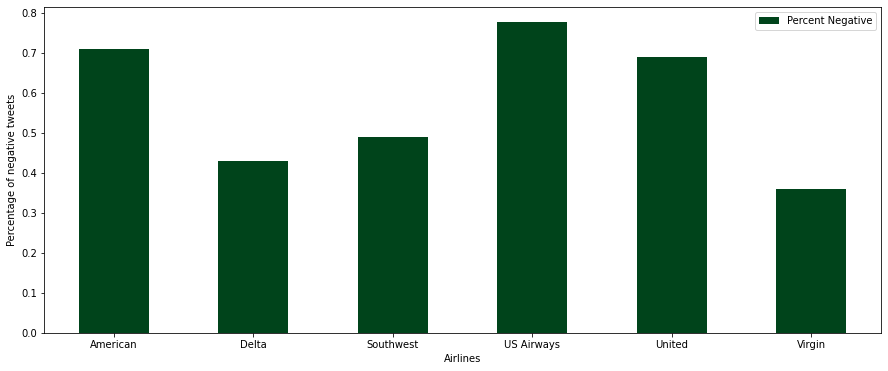

In [ ]:
neg_tweets = data_df.groupby(['airline','airline_sentiment']).count().iloc[:,0]
total_tweets = data_df.groupby(['airline'])['airline_sentiment'].count()

my_dict = {'American':neg_tweets[0] / total_tweets[0],'Delta':neg_tweets[3] / total_tweets[1],'Southwest': neg_tweets[6] / total_tweets[2],
'US Airways': neg_tweets[9] / total_tweets[3],'United': neg_tweets[12] / total_tweets[4],'Virgin': neg_tweets[15] / total_tweets[5]}
perc = pd.DataFrame.from_dict(my_dict, orient = 'index')
perc.columns = ['Percent Negative']
print(perc)
ax = perc.plot(kind = 'bar', rot=0, colormap = 'Greens_r', figsize = (15,6))
ax.set_xlabel('Airlines')
ax.set_ylabel('Percentage of negative tweets')
plt.show()

In [ ]:
# Data Preprocessing 

def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    wl = ["not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in wl) and len(word) > 1] 
    return " ".join(clean_words)

def remove_mentions(input_text):
    for i in range(len(input_text)):
        input_text[i] = re.sub(r'@\w+', '', input_text[i])
    return input_text

def lower_case(input_text):
    for i in range(len(input_text)):
        input_text[i] = input_text[i].lower()
    return input_text

def remove_http(input_text):
    for i in range(len(input_text)):
        input_text[i] = re.sub(r'http\S+', '',input_text[i])
    return input_text

def remove_punctuation(input_text):
    for i in range(len(input_text)):
        input_text[i] = re.sub(r'[^\w\s]','',input_text[i])
    return input_text


In [ ]:
import nltk
nltk.download('stopwords')

data_2 = data_df[['text', 'airline_sentiment']]
preprocessed_data = data_2.apply(remove_mentions).apply(remove_http).apply(remove_punctuation).apply(lower_case)
clean_text = []
for tweet in preprocessed_data.text:
    clean = remove_stopwords(tweet)
    clean_text.append(clean)

X = clean_text
Y = preprocessed_data['airline_sentiment']
from sklearn.model_selection import train_test_split
Y = Y.map({'negative':0, 'positive':1, 'neutral':2}).astype(int)
X_train,X_test,y_train,y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
text_features_train = vectorizer.fit_transform(X_train)
text_features_test = vectorizer.transform(X_test)

In [ ]:
from gensim.models import Word2Vec
sentences = [line.split() for line in clean_text]
w2v = Word2Vec(sentences, size=50, min_count = 0, window = 5,workers=4,iter=500)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

t = Tokenizer()
t.fit_on_texts(clean_text)
vocab_size = len(t.word_index) + 1
encoded_docs = t.texts_to_sequences(clean_text)
padded_docs = pad_sequences(encoded_docs, maxlen=20, padding='post')
embedding_dict = dict()
for i in w2v.wv.vocab:
    embedding_dict[i] = w2v[i]

embedding_matrix = np.zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
def results(labels, pred):
    print(confusion_matrix(labels,pred))  
    print(classification_report(labels,pred))  
    print(accuracy_score(labels, pred))

In [ ]:
# SVM 

def svm(training_features, labels_train, test_features, labels_test):
    for c in [1, 5, 10, 50]:
    #changing the parameter C to get the optimal classification
        model = LinearSVC(C=c)
        model.fit(training_features, labels_train)
        print ("Accuracy of svm for C=%s: %s" 
           % (c, accuracy_score(labels_train, model.predict(training_features))))
        results(labels_test, model.predict(test_features))


svm(text_features_train,y_train, text_features_test,y_test)

Accuracy of svm for C=1: 0.9564359441408622
[[847  24  53]
 [ 44 161  33]
 [115  38 149]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       924
           1       0.72      0.68      0.70       238
           2       0.63      0.49      0.55       302

    accuracy                           0.79      1464
   macro avg       0.73      0.70      0.71      1464
weighted avg       0.78      0.79      0.78      1464

0.7903005464480874
Accuracy of svm for C=5: 0.9780661809350334
[[826  28  70]
 [ 45 156  37]
 [115  37 150]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       924
           1       0.71      0.66      0.68       238
           2       0.58      0.50      0.54       302

    accuracy                           0.77      1464
   macro avg       0.71      0.68      0.69      1464
weighted avg       0.76      0.77      0.77      1464

0.773224043715847
Accuracy of svm for C

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# Naive Bayes

def naiive_bayes(training_features, labels_train, test_features, labels_test):
    clf = MultinomialNB()
    clf.fit(training_features, labels_train)
    print ("Accuracy of Naiive Bayes: %s" 
         % ( accuracy_score(labels_test, clf.predict(test_features))))
    results(labels_test, clf.predict(test_features))

naiive_bayes(text_features_train,y_train, text_features_test,y_test)    

Accuracy of Naiive Bayes: 0.6967213114754098
[[920   0   4]
 [178  55   5]
 [253   4  45]]
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       924
           1       0.93      0.23      0.37       238
           2       0.83      0.15      0.25       302

    accuracy                           0.70      1464
   macro avg       0.82      0.46      0.48      1464
weighted avg       0.75      0.70      0.62      1464

0.6967213114754098


In [ ]:
import tensorflow as tf
y_one_hot = tf.keras.utils.to_categorical(
    Y,
    num_classes=3,
    dtype='int32'
)

x_train_DL, x_test_DL,y_train_DL,y_test_DL = train_test_split(padded_docs,y_one_hot,test_size=0.1,random_state=42)

In [ ]:
# Feed forward network

model = Sequential()
embedding_layer = Embedding(vocab_size,50,embeddings_initializer = Constant(embedding_matrix),input_length=20, trainable=False)
model.add(embedding_layer)
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())
model.fit(x_train_DL,y_train_DL,epochs = 50, batch_size=128)
ans = model.predict(x_test_DL)
labels = [np.where(r==1)[0][0] for r in y_test_DL]
ans = np.argmax(ans,axis=1)
accuracy_score(ans,labels)
results(ans,labels)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 50)            726400    
_________________________________________________________________
dense (Dense)                (None, 20, 128)           6528      
_________________________________________________________________
dropout (Dropout)            (None, 20, 128)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 20, 128)           16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 7

In [ ]:
# LSTM

embedding_layer = Embedding(vocab_size,50,embeddings_initializer = Constant(embedding_matrix),input_length=20, trainable=True)
model.add(embedding_layer)
model.add(LSTM(32, activation = 'relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation = 'softmax'))
print(model.summary())
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train_DL,y_train_DL,epochs = 20,batch_size=256)
ans = model.predict(x_test_DL)
labels = [np.where(r==1)[0][0] for r in y_test_DL]
ans = np.argmax(ans,axis=1)
accuracy_score(ans,labels)
results(ans,labels)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 50)            726400    
_________________________________________________________________
dense (Dense)                (None, 20, 128)           6528      
_________________________________________________________________
dropout (Dropout)            (None, 20, 128)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 20, 128)           16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 7

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CNN

model = Sequential()
embedding_layer = Embedding(vocab_size,50,embeddings_initializer = Constant(embedding_matrix),input_length=20, trainable=False)
model.add(embedding_layer)
model.add(Convolution1D(filters=100,
                        kernel_size=5,
                        activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train_DL,y_train_DL,epochs=20)
ans = model.predict(x_test_DL)
labels = [np.where(r==1)[0][0] for r in y_test_DL]
ans = np.argmax(ans,axis=1)
accuracy_score(ans,labels)
results(ans,labels)

Epoch 1/20
412/412 [==============================] - 2s 4ms/step - loss: 0.8218 - accuracy: 0.6780
Epoch 2/20
412/412 [==============================] - 2s 4ms/step - loss: 0.5290 - accuracy: 0.7933
Epoch 3/20
412/412 [==============================] - 2s 4ms/step - loss: 0.4624 - accuracy: 0.8136
Epoch 4/20
412/412 [==============================] - 2s 4ms/step - loss: 0.3929 - accuracy: 0.8434
Epoch 5/20
412/412 [==============================] - 2s 4ms/step - loss: 0.3373 - accuracy: 0.8733
Epoch 6/20
412/412 [==============================] - 2s 4ms/step - loss: 0.2601 - accuracy: 0.9012
Epoch 7/20
412/412 [==============================] - 2s 4ms/step - loss: 0.2286 - accuracy: 0.9109
Epoch 8/20
412/412 [==============================] - 2s 4ms/step - loss: 0.1755 - accuracy: 0.9367
Epoch 9/20
412/412 [==============================] - 2s 4ms/step - loss: 0.1527 - accuracy: 0.9428
Epoch 10/20
412/412 [==============================] - 2s 4ms/step - loss: 0.1525 - accuracy: 0.9427